# R4 on DECOY_MNIST

In [2]:
%load_ext autoreload
%autoreload 2
import torch
import tqdm
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))
import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training import certified_training_utils as ct_utils
from models.fully_connected import FullyConnected
from models.robust_regularizer import input_gradient_interval_regularizer
from datasets import decoy_mnist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-train the model

In [3]:
# set up pre-training
CUDA_LAUNCH_BLOCKING=1
SEED = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(SEED)

cuda:0


In [4]:
batch_size = 1000
dl_train, dl_test = decoy_mnist.get_dataloaders(batch_size)

/home/raoden/phd_projects/R4/examples/datasets/decoy_mnist.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_imgs = torch.tensor(train_imgs.clone().detach(), dtype=torch.float32).unsqueeze(1) / 255
/home/raoden/phd_projects/R4/examples/datasets/decoy_mnist.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_imgs = torch.tensor(test_imgs.clone().detach(), dtype=torch.float32).unsqueeze(1) / 255
/home/raoden/phd_projects/R4/examples/datasets/decoy_mnist.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch

In [5]:
# Extract the swatches values for each different label
train_label_tensors = dl_train.dataset.tensors[1]
train_input_tensors = dl_train.dataset.tensors[0]
indices = [((train_label_tensors == i).nonzero()[0], i) for i in range(10)]
reshaped = [(torch.reshape(train_input_tensors[idx], (28, 28)), label) for idx, label in indices]
corner_indices = (0, 0), (0, 27), (27, 0), (27, 27)
swatches_color_dict = {}
for r, label in reshaped:
    for i, j in corner_indices:
        if r[i][j] > 0:
            swatches_color_dict[label] = r[i][j]
            continue

print(swatches_color_dict)

{0: tensor(0.3333), 1: tensor(0.2980), 2: tensor(0.2667), 3: tensor(0.2353), 4: tensor(0.2000), 5: tensor(0.1686), 6: tensor(0.1373), 7: tensor(0.1020), 8: tensor(0.0706), 9: tensor(0.0392)}


In [6]:
# make a corner mask
check_mask = torch.zeros(1, 28, 28)
corner_mask = torch.ones(4, 4)
check_mask[:, :4, :4] = corner_mask
check_mask[:, -4:, :4] = corner_mask
check_mask[:, :4, -4:] = corner_mask
check_mask[:, -4:, -4:] = corner_mask
check_mask = torch.reshape(check_mask, (1, 784))
# Extract the dataset from the dataloader
train_data_inputs, train_data_labels = dl_train.dataset.tensors[0], dl_train.dataset.tensors[1] # i.e. the first tuple element, which is the input
num_elems_train = train_data_inputs.shape[0]
# So, mark as 1 the irrelevant features
train_masks = torch.empty_like(train_data_inputs)
for idx, (input, label) in enumerate(zip(train_data_inputs, train_data_labels)):
    train_masks[idx] = torch.where(torch.isclose(input, swatches_color_dict[int(label)], atol=1e-5), 1, 0)
    train_masks[idx] *= check_mask
masks_dset = torch.utils.data.TensorDataset(train_data_inputs, train_data_labels, train_masks)
dl_masks_train = torch.utils.data.DataLoader(masks_dset, batch_size=batch_size, shuffle=True)
# Now construct masks for the test set
test_data_inputs, test_data_labels = dl_test.dataset.tensors[0], dl_test.dataset.tensors[1]
num_elems_test = test_data_inputs.shape[0]
test_masks = torch.empty_like(test_data_inputs)
for idx, (input, label) in enumerate(zip(test_data_inputs, test_data_labels)):
    test_masks[idx] = torch.where(torch.isclose(input, swatches_color_dict[int(label)], atol=1e-5), 1, 0)
    test_masks[idx] *= check_mask
masks_dset = torch.utils.data.TensorDataset(test_data_inputs, test_data_labels, test_masks)
dl_masks_test = torch.utils.data.DataLoader(masks_dset, batch_size=batch_size, shuffle=True)

In [20]:
def train_model_with(n_epochs, model, learning_rate, criterion, epsilon, mlx_method, k):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # pre-train the model
    progress_bar = tqdm.trange(n_epochs, desc="Epoch", )
    for _ in progress_bar:
        for i, (x, u, m) in enumerate(dl_masks_train):
            # Forward pass
            u, x = u.to(device), x.to(device).flatten(start_dim=1)
            m = m.to(device).flatten(start_dim=1)

            output = model(x)
            # For std, we will waste some time doing the bounds, but at least it is consistent across methods
            inp_grad_reg = input_gradient_interval_regularizer(
                model, x, u, "cross_entropy", epsilon, 0.0, regularizer_type=mlx_method, batch_masks=m
            )
            if mlx_method == "std":
                u = torch.nn.functional.one_hot(u, num_classes=10).squeeze().float()
                assert inp_grad_reg == 0
            loss = criterion(output, u) + k * inp_grad_reg
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                progress_bar.set_postfix(loss=loss.item())

In [21]:
def test_model_acc(model):
    # evaluate the pre-trained model
    # here, param_n, param_l, param_u are the parameters of the model and l and u are the same (we did not poison)
    param_n, param_l, param_u = ct_utils.get_parameters(model)
    all_acc, i = 0, 0
    for test_batch, test_labels in dl_test:
        all_acc += agt.test_metrics.test_accuracy(param_n, param_l, param_u, test_batch, test_labels, model=model)[1]
        i += 1
    all_acc /= i
    print("--- Pre-trained model accuracy ---")
    print(f"Nominal = {all_acc:.2g}")

In [22]:
def visualize_gradient(model, batch_input, batch_labels, batch_mask, elem_idx):
    batch_input, batch_labels = batch_input.to(device).flatten(start_dim=1), batch_labels.to(device)
    grad_bounds = input_gradient_interval_regularizer(
        model, batch_input, batch_labels, "cross_entropy", 0.1, 0.0, return_grads=True, regularizer_type="r4", batch_masks=batch_mask
    )
    dx_l, dx_u = grad_bounds[1]
    dx_n, _ = grad_bounds[0]
    fig, ax = plt.subplots(3, 2, figsize=(14, 13))
    ax[0][0].imshow(batch_input[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][0].set_title(f"Input at index {elem_idx}")
    im_mask = ax[0][1].imshow(batch_mask[elem_idx].cpu().numpy().reshape(28, 28), cmap='gray')
    ax[0][1].set_title(f"Mask at index {elem_idx}")
    fig.colorbar(im_mask, ax=ax[0][1])
    im_dx_l = ax[1][0].imshow(dx_l[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][0].set_title(f"Lower bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_l, ax=ax[1][0])
    im_dx_u = ax[1][1].imshow(dx_u[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[1][1].set_title(f"Upper bound of gradient at index {elem_idx}")
    fig.colorbar(im_dx_u, ax=ax[1][1])
    im_dx_n = ax[2][0].imshow(dx_n[elem_idx].cpu().detach().numpy().reshape(28, 28), cmap='coolwarm')
    ax[2][0].set_title(f"Gradient at index {elem_idx}")
    fig.colorbar(im_dx_n, ax=ax[2][0])

In [23]:
# define model, dataset and optimizer
num_epochs = 10
lr = 0.01
restarts = 3
epsilon = 0.1
# k is a coefficient for the regularization term
k = 0.2
ARCH = (784, 10, 512, 1)
model = FullyConnected(*ARCH)
model.append(torch.nn.Softmax(dim=1))
criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
print(model)

FullyConnected(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=10, bias=True)
  (3): Softmax(dim=1)
)


Batch input shape: torch.Size([1000, 1, 784]), batch mask shape: torch.Size([1000, 1, 784])


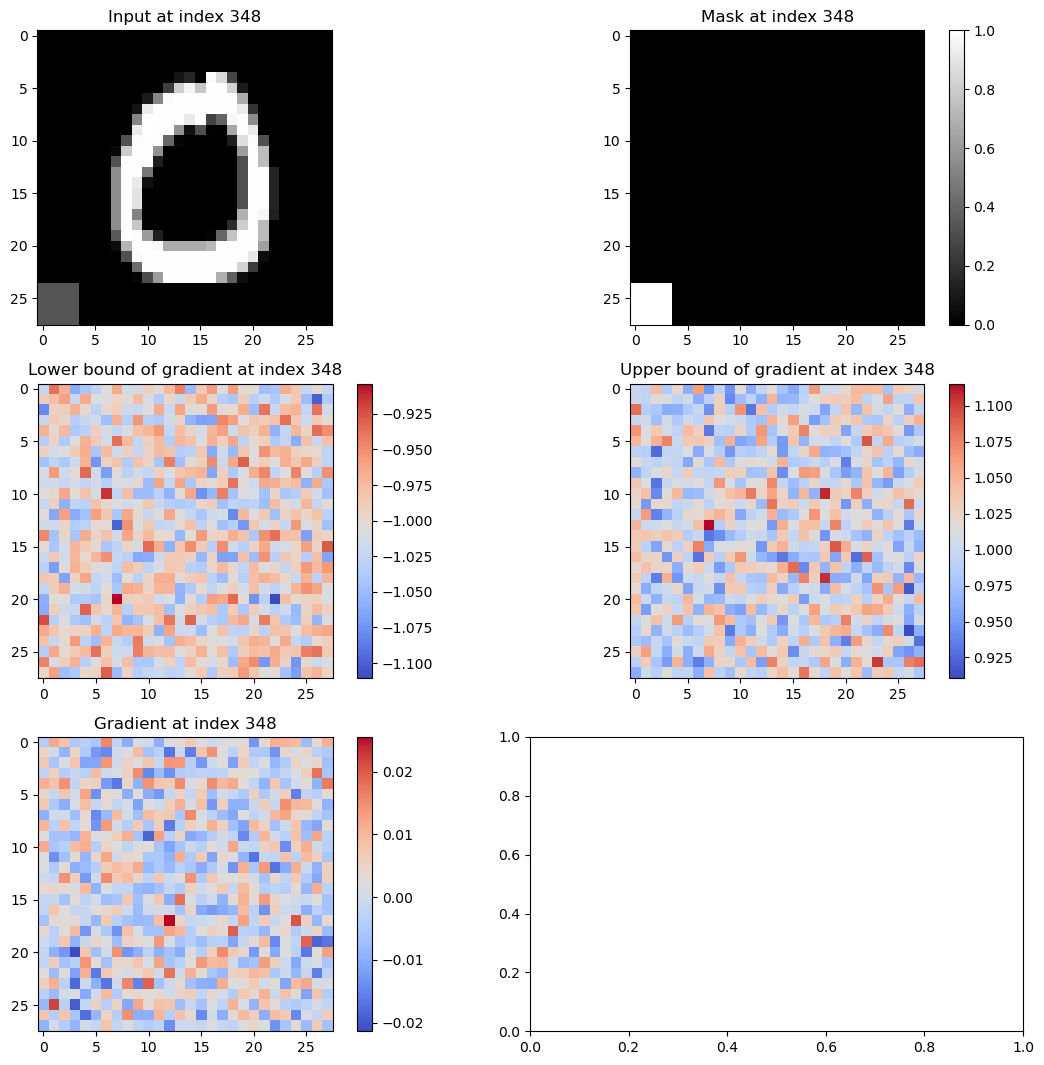

In [24]:
idx_to_visualize = torch.randint(0, batch_size, (1,)).item()
init_batch_train_with_masks = next(iter(dl_masks_train))
print(f"Batch input shape: {init_batch_train_with_masks[0].shape}, batch mask shape: {init_batch_train_with_masks[2].shape}")
visualize_gradient(model, *init_batch_train_with_masks, idx_to_visualize)

## Experiments 

In [25]:
DELTA_INPUT_ROBUSTNESS_PARAM = 0.1

In [26]:
def test_delta_input_robustness(model):
    num_robust, i = 0, 0
    test_batch_size = dl_test.batch_size
    for test_batch, test_labels, test_masks in dl_masks_test:
        test_batch, test_labels, test_masks = test_batch.to(device), test_labels.to(device), test_masks.to(device)
        test_batch = test_batch.flatten(start_dim=1)
        test_masks = test_masks.flatten(start_dim=1)
        # The MLX method does not really matter, as we return the grads
        grad_bounds = input_gradient_interval_regularizer(model, test_batch, test_labels, "cross_entropy", epsilon, 0.0, return_grads=True, batch_masks=test_masks)
        d_l, d_u = grad_bounds[1]
        abs_diff = torch.abs(d_l - d_u)
        robust_grad_inputs = torch.where(abs_diff <= DELTA_INPUT_ROBUSTNESS_PARAM, 1, 0).bool()
        is_robust_grad = robust_grad_inputs.all(dim=-1)
        num_robust += is_robust_grad.sum().item() / test_batch_size
        i += 1
    num_robust /= i
    print("--- Pre-trained model delta input robustness ---")
    print(f"Delta Input Robustness = {num_robust:.2g}")


### Standard Training

========== Training model with method std restart 0 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.68
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0
========== Training model with method std restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it, loss=1.47]


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0
========== Training model with method std restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it, loss=1.46]


--- Pre-trained model accuracy ---
Nominal = 0.7
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0


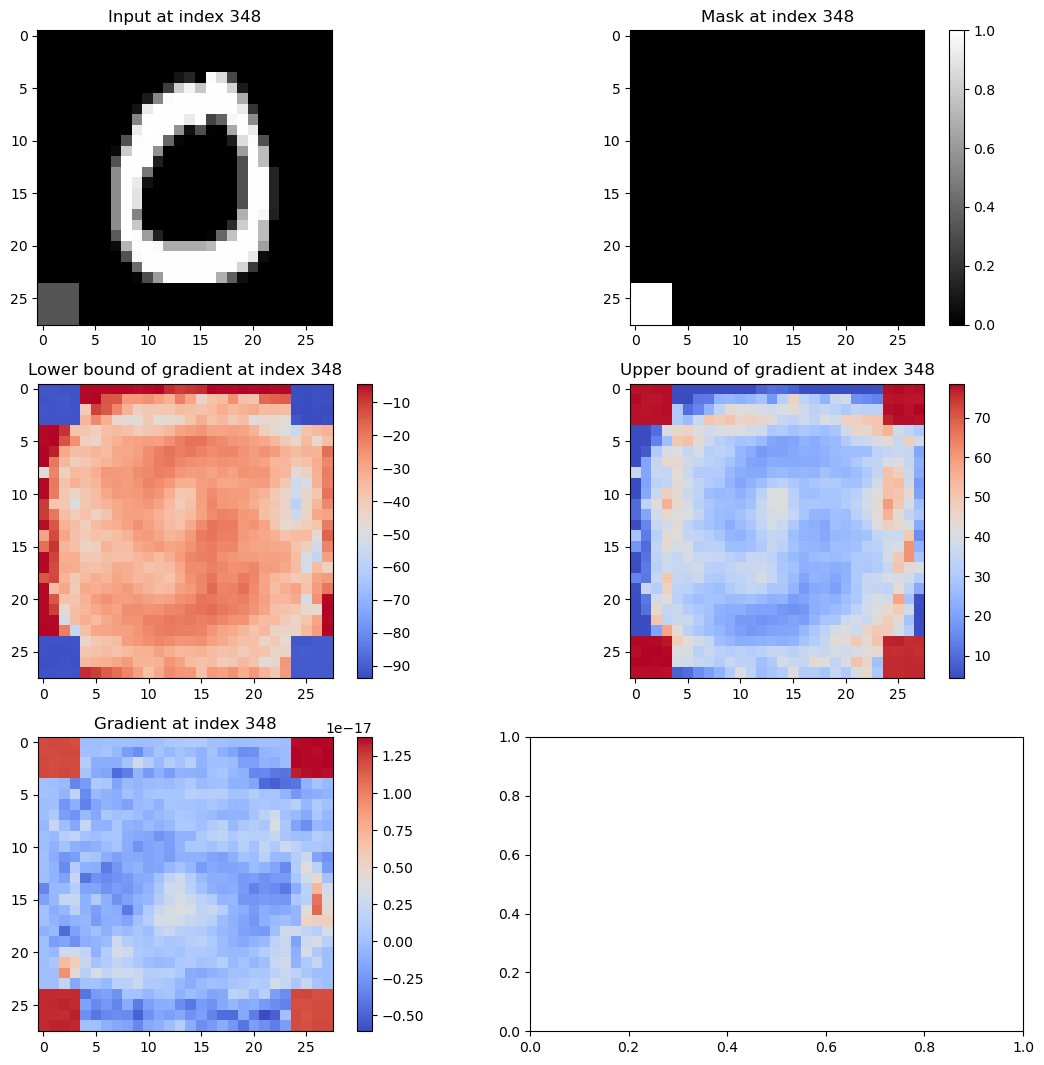

In [27]:
mlx_method = "std"
# Train standard 3 times and test accuracy and delta input robustness for the masked region
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method {mlx_method} restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, mlx_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, idx_to_visualize)

### RRR Training

========== Training model with method r3, restart 0 ==========


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.68s/it, loss=221]   


--- Pre-trained model accuracy ---
Nominal = 0.68
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0
========== Training model with method r3, restart 1 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=203]   


--- Pre-trained model accuracy ---
Nominal = 0.69
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0
========== Training model with method r3, restart 2 ==========


Epoch: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it, loss=66.1]


--- Pre-trained model accuracy ---
Nominal = 0.7
--- Pre-trained model delta input robustness ---
Delta Input Robustness = 0


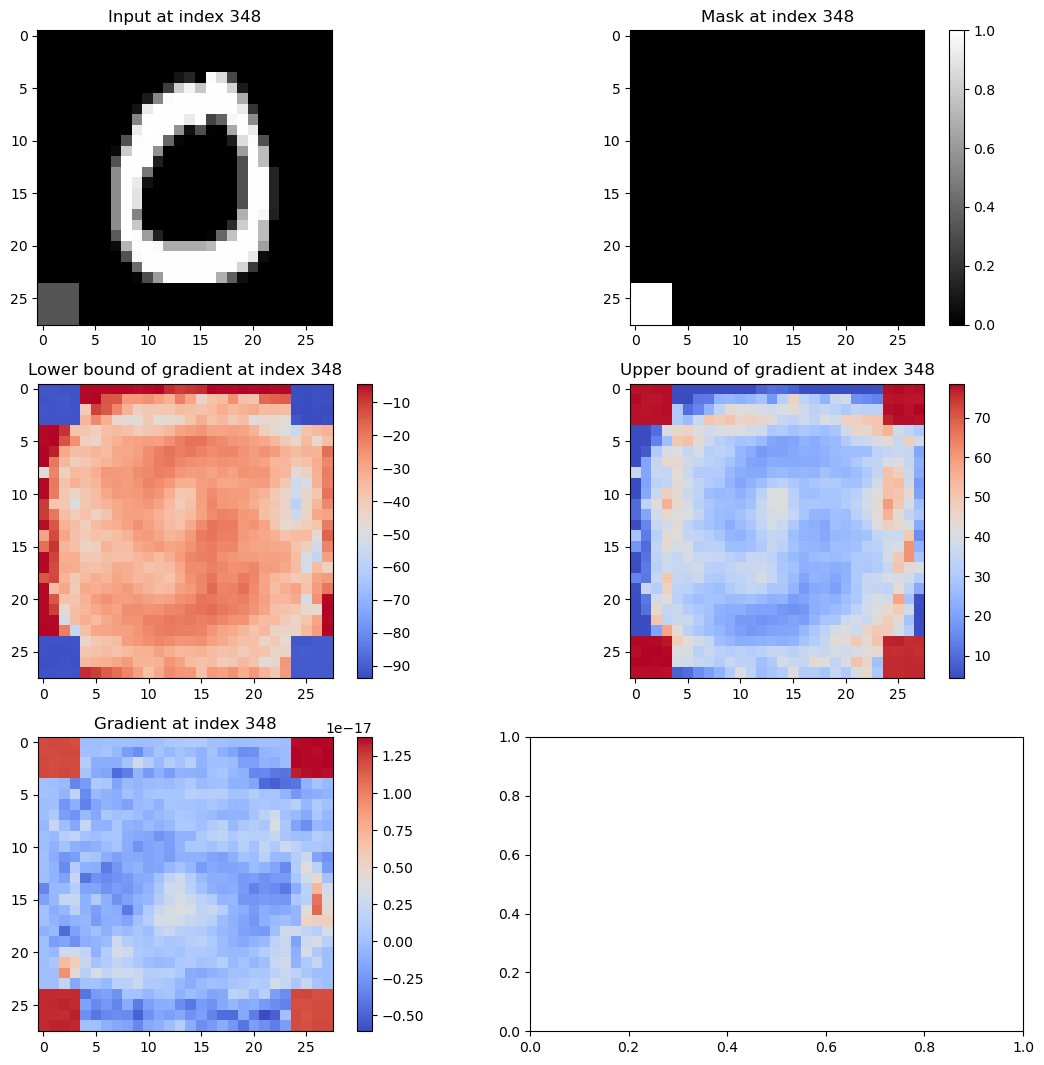

In [28]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
rrr_method = "r3"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method {rrr_method}, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, rrr_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, idx_to_visualize)

In [29]:
# Train standard 3 times and test accuracy and delta input robustness for the masked region
r4_method = "r4"
for i in range(restarts):
    # Reinitialize the model
    # We could try to just reinitialize the weights, but we can throw away the previous model for now as we do not need it
    torch.manual_seed(i + SEED)
    curr_model = FullyConnected(*ARCH)
    curr_model.append(torch.nn.Softmax(dim=1))
    curr_model = curr_model.to(device)

    print(f"========== Training model with method R4, restart {i} ==========")
    train_model_with(num_epochs, curr_model, lr, criterion, epsilon, r4_method, k)
    test_model_acc(curr_model)
    test_delta_input_robustness(curr_model)
    if i == restarts - 1:
        visualize_gradient(curr_model, *init_batch_train_with_masks, idx_to_visualize)

========== Training model with method R4, restart 0 ==========


TypeError: train_model_with() missing 1 required positional argument: 'k'